In [1]:
import cv2                                # state of the art computer vision algorithms library
import numpy as np                        # fundamental package for scientific computing
import matplotlib.pyplot as plt           # 2D plotting library producing publication quality figures
import pyrealsense2 as rs                 # Intel RealSense cross-platform open-source API

from PIL import Image

In [2]:
# Configure depth and color streams
pipeline = rs.pipeline()
config = rs.config()

# Get device product line for setting a supporting resolution
pipeline_wrapper = rs.pipeline_wrapper(pipeline)
pipeline_profile = config.resolve(pipeline_wrapper)
device = pipeline_profile.get_device()
device_product_line = str(device.get_info(rs.camera_info.product_line))

print('Device Name:', device_product_line)
for s in device.sensors:
    print(s)

Device Name: D400
<pyrealsense2.sensor: "Stereo Module">
<pyrealsense2.sensor: "RGB Camera">
<pyrealsense2.sensor: "Motion Module">


In [3]:
# Start streaming
config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)
config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)
profile = pipeline.start(config)

# Capture frames
frames = pipeline.wait_for_frames()
color_frame = frames.get_color_frame()
depth_frame = frames.get_depth_frame()

# Stop streaming
pipeline.stop()

In [4]:
# Convert images to numpy arrays
color_image = np.asanyarray(color_frame.get_data())[:,:,::-1] # images are stored as BGR instead of RGB
depth_image = np.asanyarray(depth_frame.get_data()) # values are in millimeters

print('Color image shape:', color_image.shape)
print('Depth image shape:', depth_image.shape)

Color image shape: (480, 640, 3)
Depth image shape: (480, 640)


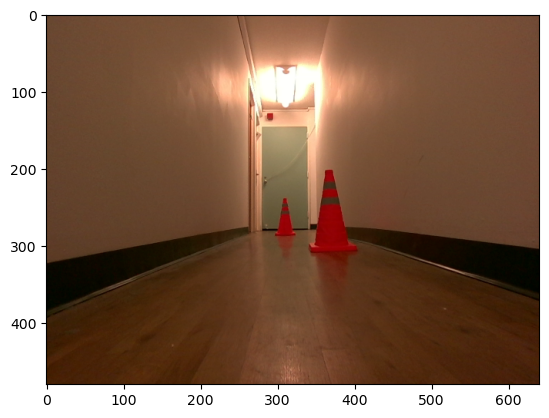

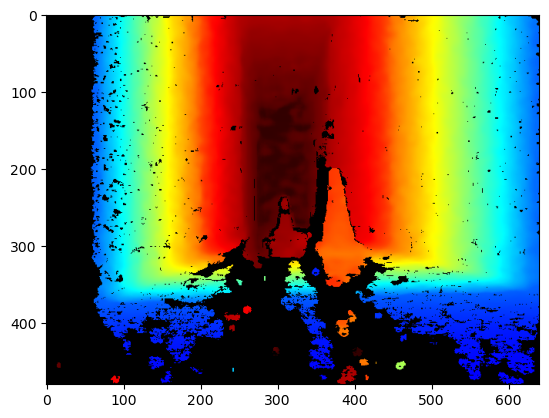

In [5]:
plt.imshow(color_image)
plt.show()

colorizer = rs.colorizer()
colorized_depth_image = np.asanyarray(colorizer.colorize(depth_frame).get_data())
plt.imshow(colorized_depth_image)
plt.show()

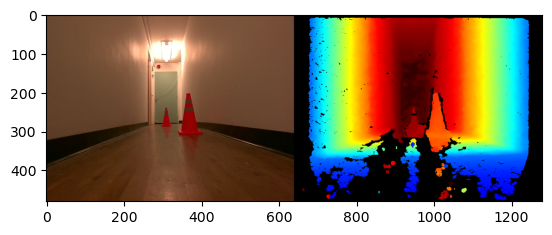

In [6]:
'''
Stream Alignment:

Upon closer inspection you can notice that the two frames are not captured from the same physical viewport.
To combine them into a single RGBD image, let's align depth data to color viewport:
'''

# Create alignment primitive with color as its target stream:
align = rs.align(rs.stream.color)
frames = align.process(frames)

# Update color and depth frames:
aligned_depth_frame = frames.get_depth_frame()
colorized_depth_image = np.asanyarray(colorizer.colorize(aligned_depth_frame).get_data())

# Show the two frames together:
images = np.hstack((color_image, colorized_depth_image))
plt.imshow(images)

# Save Images
pil_color = Image.fromarray(color_image, 'RGB')
pil_depth = Image.fromarray(colorized_depth_image, 'RGB')
pil_color.save('calibration_images/cone_color2.png', 'PNG')
pil_depth.save('calibration_images/cone_depth2.png', 'PNG')

In [7]:
#depth_scale = 0.0010000000474974513
depth = np.asanyarray(aligned_depth_frame.get_data())# * depth_scale
np.save('calibration_images/cone_depth_array2.npy', depth)

In [22]:
# Loading the image
img = cv2.imread('calibration_images/cone_color.png', cv2.IMREAD_GRAYSCALE)

# Select bounding box for SIFT features
# Opencv is weird and uses (col, row) for points, not (row, col)
top_left = (200, 370)
bottom_right = (340, 450)
   
#cv2.line(img, (400, 220), (450, 220), (0, 255, 0), thickness=3, lineType=8)
#cv2.line(img, (400, 220), (400, 350), (0, 255, 0), thickness=3, lineType=8)
#cv2.line(img, (450, 350), (450, 220), (0, 255, 0), thickness=3, lineType=8)
#cv2.line(img, (450, 350), (400, 350), (0, 255, 0), thickness=3, lineType=8)
#plt.imshow(img, cmap='gray')
#plt.show

# Initiate SIFT detector
sift = cv2.SIFT_create(nfeatures=2000)
 
# find the keypoints and descriptors with SIFT
kp, des = sift.detectAndCompute(img,None)

# Find best matches of keypoints other than with itself
matches = []
for i, (p1, d1) in enumerate(zip(kp, des)):
    best_match1 = None
    best_match2 = None
    min_dist1 = np.inf
    min_dist2 = np.inf
    for j, (p2, d2) in enumerate(zip(kp, des)):
        if j == i:
            pass
            #continue
        l2_dist = np.linalg.norm(np.array(d1) - np.array(d2)) 
        if l2_dist < min_dist1:
            min_dist1 = l2_dist
            best_match1 = (j, l2_dist)
        elif l2_dist < min_dist2:
            min_dist2 = l2_dist
            best_match2 = (j, l2_dist)
        
    matches.append((i, best_match1, best_match2))

print(matches)

# Apply Lowe's ratio test
good = []
for i, m, n in matches:
    if m[1] < 1*n[1]:
        good.append((i, m[0]))
good = tuple(set([tuple(sorted(pair)) for pair in good]))

# Remove points that are outside of selected reference object bounding box
filtered_good = []
for pair in good:
    p1 = kp[pair[0]].pt
    p2 = kp[pair[1]].pt

    if top_left[0] < p1[0] < bottom_right[0] and top_left[1] < p1[1] < bottom_right[1] \
       or top_left[0] < p2[0] < bottom_right[0] and top_left[1] < p2[1] < bottom_right[1]:
        filtered_good.append(pair)
filtered_good_kps = [kp[p[0]] for p in filtered_good]

print(filtered_good)
print(filtered_good_kps)

[(0, (0, 0.0), (1, 117.46489)), (1, (1, 0.0), (5, 211.27707)), (2, (2, 0.0), (4, 98.13256)), (3, (3, 0.0), (59, 451.5905)), (4, (4, 0.0), (5, 111.77209)), (5, (5, 0.0), (117, 195.8724)), (6, (6, 0.0), (102, 257.6684)), (7, (7, 0.0), (97, 360.33456)), (8, (8, 0.0), (69, 415.64648)), (9, (9, 0.0), (66, 366.81467)), (10, (10, 0.0), (17, 304.87375)), (11, (11, 0.0), (12, 187.44066)), (12, (12, 0.0), (86, 343.2521)), (13, (13, 0.0), (16, 372.705)), (14, (14, 0.0), (86, 392.9631)), (15, (15, 0.0), (17, 265.47318)), (16, (16, 0.0), (83, 366.37277)), (17, (17, 0.0), (21, 228.09647)), (18, (18, 0.0), (19, 56.008926)), (19, (19, 0.0), (116, 341.55527)), (20, (20, 0.0), (96, 305.3817)), (21, (21, 0.0), (83, 278.49417)), (22, (22, 0.0), (116, 310.83597)), (23, (23, 0.0), (30, 384.5894)), (24, (24, 0.0), (46, 309.60458)), (25, (25, 0.0), (44, 335.83032)), (26, (26, 0.0), (103, 429.1247)), (27, (27, 0.0), (114, 386.63678)), (28, (28, 0.0), (19, 400.68066)), (29, (29, 0.0), (46, 326.60986)), (30, (30

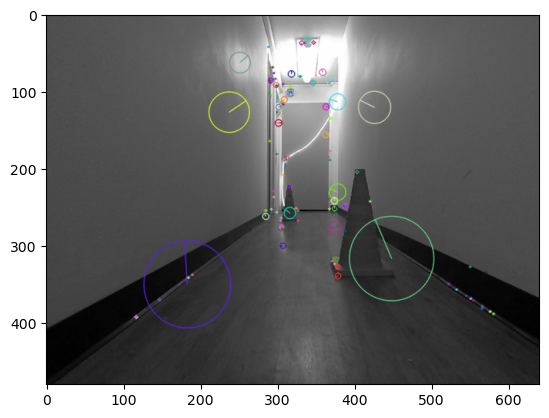

In [25]:
img=cv2.drawKeypoints(img, filtered_good_kps, img, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

#cv2.line(img, (400, 220), (450, 220), (255, 0, 0), thickness=3, lineType=8)
#cv2.line(img, (400, 220), (400, 350), (255, 0, 0), thickness=3, lineType=8)
#cv2.line(img, (450, 350), (450, 220), (255, 0, 0), thickness=3, lineType=8)
#cv2.line(img, (450, 350), (400, 350), (255, 0, 0), thickness=3, lineType=8)

for pair in filtered_good:
    p1 = (int(kp[pair[0]].pt[0]), int(kp[pair[0]].pt[1]))
    p2 = (int(kp[pair[1]].pt[0]), int(kp[pair[1]].pt[1]))
    cv2.line(img, p1, p2, (0, 255, 0), thickness=3, lineType=8)

plt.imshow(img)

In [191]:
# Get depth of reference object
depth_scale = 0.0010000000474974513
depth = np.asanyarray(aligned_depth_frame.get_data()) * depth_scale

ref_depth = np.median(depth[220:350, 400:450])
print(ref_depth)

target_depth = np.median(depth[232:289, 227:249])
print(target_depth)

0.4790000227512792
1.0560000501573086


In [195]:
# Distance between SIFT feature 1 and 2
ref_feat1 = kp[filtered_good[0][0]].pt
target_feat1 = kp[filtered_good[0][1]].pt

ref_feat2 = kp[filtered_good[1][0]].pt
target_feat2 = kp[filtered_good[1][1]].pt

ref_dist = np.linalg.norm(np.array(ref_feat1) - np.array(ref_feat2))
target_dist = np.linalg.norm(np.array(target_feat1) - np.array(target_feat2))
print(target_dist)

62.768515547692324
